In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max, expr, percentile_approx

# Crea una sesión de Spark
print("Creando sesión de Spark...")
spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "/src/sparkml/postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "/src/sparkml/postgresql-42.2.14.jar") \
    .getOrCreate()


# Ruta del archivo CSV
data_path = "/home/jovyan/work/data/Titanic-Dataset.csv"

# Se carga el archivo CSV en un DataFrame de PySpark 
df = spark.read.csv(data_path, header=True, inferSchema=True)

# === Se muestra el esquema del DataFrame para confirmar la estructura de los datos ===
print("=== Esquema del DataFrame cargado ===")
df.printSchema()

# === Se muestra las primeras filas del DataFrame para verificar la carga exitosa ===
print("\n=== Muestra de las primeras filas del DataFrame ===")
df.show(5, truncate=False)



Creando sesión de Spark...
=== Esquema del DataFrame cargado ===
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)


=== Muestra de las primeras filas del DataFrame ===
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|Name                                               |Sex   |Age |SibSp|Parch|Ticket          |Fare   |Cabin|Embarked|
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-----

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max, expr

df = spark.read.csv(data_path, header=True, inferSchema=True)

# === Conteo total de filas antes de la imputación ===
total_filas_original = df.count()
print(f"Total de filas en el dataset antes de la imputación: {total_filas_original}")

# === Conteo de valores nulos en cada columna ===
print("\n=== Conteo de valores nulos en cada columna ===")
null_counts_df = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts_df.show(truncate=False)

# === Imputar valores nulos en 'Cabin' con "Desconocido" ===
df_clean = df.na.fill({"Cabin": "Desconocido"})

# === Imputar valores nulos en 'Age' con la mediana ===
median_age = df.approxQuantile("Age", [0.5], 0.01)[0]
df_clean = df_clean.na.fill({"Age": median_age})

# === Imputar valores nulos en 'Embarked' con "Desconocido" ===
df_clean = df_clean.na.fill({"Embarked": "Desconocido"})

# === Conteo total de filas después de la imputación ===
total_filas_despues = df_clean.count()
print(f"Total de filas en el dataset después de la imputación: {total_filas_despues}")

# === Resumen estadístico completo por columna numérica ===
numeric_columns = ["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]

for column in numeric_columns:
    print(f"=== Resumen estadístico para la columna '{column}' ===")
    
    # Calcula el conteo
    count_value = df_clean.select(count(column)).collect()[0][0]
    
    # Calcula la media
    mean_value = df_clean.select(mean(column)).collect()[0][0]
    
    # Calcula la desviación estándar
    stddev_value = df_clean.select(stddev(column)).collect()[0][0]
    
    # Calcula el mínimo
    min_value = df_clean.select(min(column)).collect()[0][0]
    
    # Calcula el máximo
    max_value = df_clean.select(max(column)).collect()[0][0]
    
    # Resumen para la columna actual
    print(f"Count: {count_value}")
    print(f"Mean: {mean_value:.2f}" if mean_value is not None else "Mean: None")
    print(f"Stddev: {stddev_value:.2f}" if stddev_value is not None else "Stddev: None")
    print(f"Min: {min_value}")
    print(f"Max: {max_value}")
    print("-" * 40)

# === Percentiles adicionales y mediana para 'Age' y 'Fare' ===
print("\n=== Percentiles Adicionales y Mediana para 'Age' y 'Fare' ===")
percentiles_df = df_clean.select(
    expr("percentile_approx(Age, 0.25)").alias("Age_25%"),
    expr("percentile_approx(Age, 0.5)").alias("Age_Median"),
    expr("percentile_approx(Age, 0.75)").alias("Age_75%"),
    expr("percentile_approx(Fare, 0.25)").alias("Fare_25%"),
    expr("percentile_approx(Fare, 0.5)").alias("Fare_Median"),
    expr("percentile_approx(Fare, 0.75)").alias("Fare_75%")
)
percentiles_df.show(truncate=False)

# === Verificación final de valores nulos en cada columna después de la imputación ===
print("\n=== Verificación de valores nulos en cada columna después de la imputación ===")
null_counts_after_df = df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df_clean.columns])
null_counts_after_df.show(truncate=False)




Total de filas en el dataset antes de la imputación: 891

=== Conteo de valores nulos en cada columna ===
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|0          |0       |0     |0   |0  |177|0    |0    |0     |0   |687  |2       |
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

Total de filas en el dataset después de la imputación: 891
=== Resumen estadístico para la columna 'PassengerId' ===
Count: 891
Mean: 446.00
Stddev: 257.35
Min: 1
Max: 891
----------------------------------------
=== Resumen estadístico para la columna 'Survived' ===
Count: 891
Mean: 0.38
Stddev: 0.49
Min: 0
Max: 1
----------------------------------------
=== Resumen estadístico para la columna 'Pclass' ===
Count: 891
Mean: 2.31
Stddev: 0.84
Min: 1
Max: 3
-----------------------

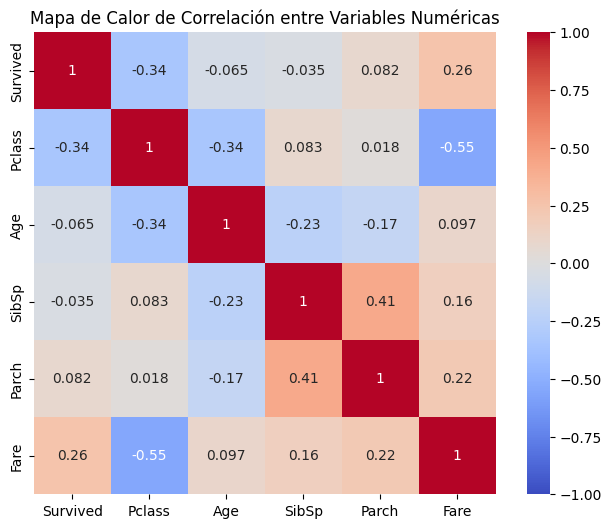

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de columnas numéricas
numeric_columns = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]

# Crea una matriz de correlación
correlation_matrix = []

for col1 in numeric_columns:
    row = []
    for col2 in numeric_columns:
        correlation = df_clean.stat.corr(col1, col2)
        row.append(correlation)
    correlation_matrix.append(row)


plt.figure(figsize=(8, 6))

# se crea el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True,
            xticklabels=numeric_columns, yticklabels=numeric_columns)


plt.title("Mapa de Calor de Correlación entre Variables Numéricas")
plt.show()




=== Conteo de cada categoría en 'Survived' ===
+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



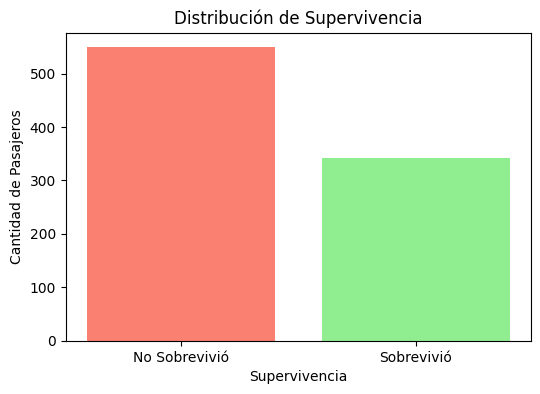

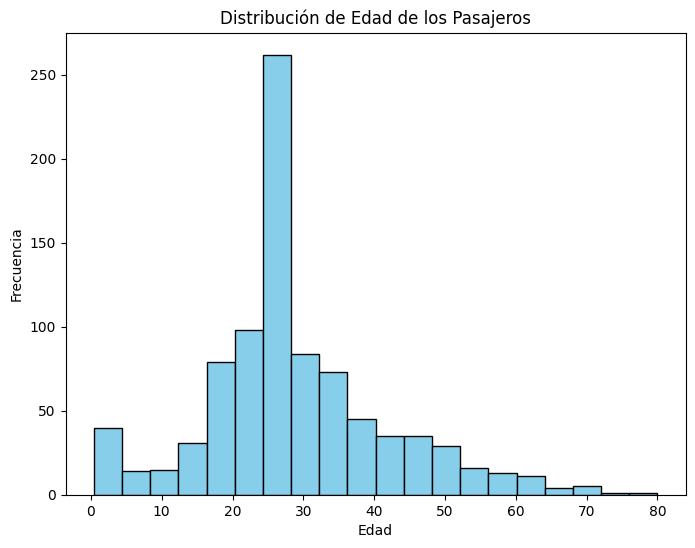

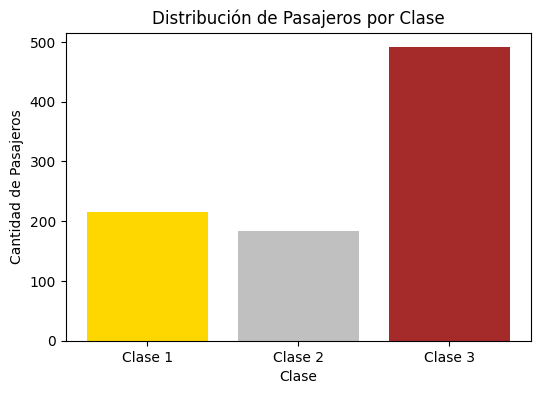

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt

df = spark.read.csv(data_path, header=True, inferSchema=True)

# === 2. Se hace un count de sobrevivientes y no sobrevivientes en el DataFrame ===
print("\n=== Conteo de cada categoría en 'Survived' ===")
df_clean.groupBy("Survived").count().show()

# Se extrae los datos de supervivencia para el gráfico
survived_counts = df_clean.groupBy("Survived").count().orderBy("Survived").collect()
survived_counts_list = [row["count"] for row in survived_counts]  # Convertir en lista para el gráfico

# === 3. Visualización de la Distribución de Supervivencia ===
plt.figure(figsize=(6, 4))
plt.bar(["No Sobrevivió", "Sobrevivió"], survived_counts_list, color=["salmon", "lightgreen"])
plt.title("Distribución de Supervivencia")
plt.xlabel("Supervivencia")
plt.ylabel("Cantidad de Pasajeros")
plt.show()

# === 4. Otros gráficos para análisis adicionales ===
# Histograma de la Distribución de Edad (Age)
age_data = df_clean.select("Age").rdd.flatMap(lambda x: x).collect()  # Aquí ya no deberían haber nulos
plt.figure(figsize=(8, 6))
plt.hist(age_data, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribución de Edad de los Pasajeros")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

# Gráfico de Barras para la Distribución de Clases de Pasajero (Pclass)
pclass_counts = df_clean.groupBy("Pclass").count().orderBy("Pclass").collect()
pclass_counts_list = [row["count"] for row in pclass_counts]

plt.figure(figsize=(6, 4))
plt.bar(["Clase 1", "Clase 2", "Clase 3"], pclass_counts_list, color=["gold", "silver", "brown"])
plt.title("Distribución de Pasajeros por Clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Pasajeros")
plt.show()


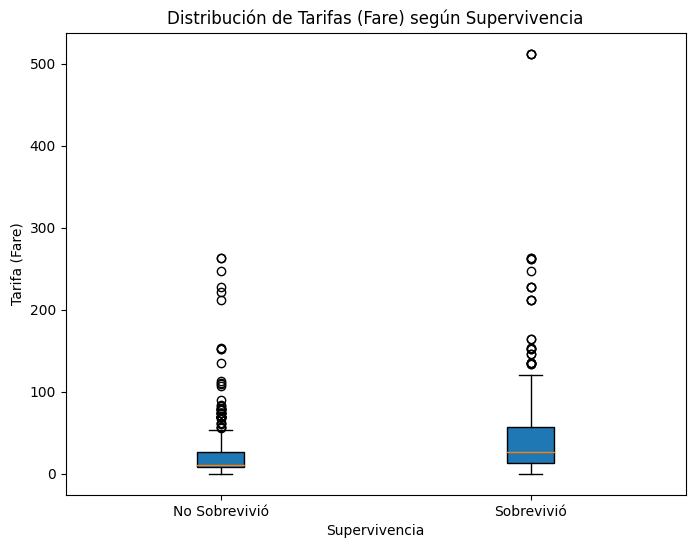

In [32]:
# === 5. Boxplot para 'Fare' según 'Survived' ===
fare_survived_data = df_clean.select("Fare", "Survived").rdd.map(lambda row: (row["Survived"], row["Fare"])).groupByKey().mapValues(list).collectAsMap()

plt.figure(figsize=(8, 6))
plt.boxplot([fare_survived_data[0], fare_survived_data[1]], labels=["No Sobrevivió", "Sobrevivió"], patch_artist=True)
plt.title("Distribución de Tarifas (Fare) según Supervivencia")
plt.xlabel("Supervivencia")
plt.ylabel("Tarifa (Fare)")
plt.show()


In [33]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
import matplotlib.pyplot as plt
#Estandarizacion

# selecciona las columnas numéricas para estandarizarlas
numeric_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

# convierte las columnas que son numeros a un vector
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = vector_assembler.transform(df_clean)

# estandariza
standard_scaler = StandardScaler(inputCol="features", outputCol="standardized_features", withMean=True, withStd=True)

# ajusta el scaler a los datos
scaler_model = standard_scaler.fit(df_vector)

# transforma el DataFrame
standardized_data = scaler_model.transform(df_vector)


standardized_data.select("features", "standardized_features").show(truncate=False)

+--------------------------+---------------------------------------------------------------------------------------------------------+
|features                  |standardized_features                                                                                    |
+--------------------------+---------------------------------------------------------------------------------------------------------+
|[3.0,22.0,1.0,0.0,7.25]   |[0.8269128165243681,-0.5654188991856529,0.43255042804180244,-0.47340772456838975,-0.5021631365156044]    |
|[1.0,38.0,1.0,0.0,71.2833]|[-1.5652278312782775,0.6634883904242593,0.43255042804180244,-0.47340772456838975,0.7864036178345394]     |
|[3.0,26.0,0.0,0.0,7.925]  |[0.8269128165243681,-0.2581920767831749,-0.4742788222764235,-0.47340772456838975,-0.4885798515812601]    |
|[1.0,35.0,1.0,0.0,53.1]   |[-1.5652278312782775,0.43306827362240075,0.43255042804180244,-0.47340772456838975,0.4204940697654103]    |
|[3.0,35.0,0.0,0.0,8.05]   |[0.8269128165243681,0.43306

In [39]:
# Almacenar el conjunto de datos limpio en la base de datos
df_clean \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

In [40]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|      Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|Desconocido|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|        C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|Desconocido|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|Desconocido|       S|
|          6|       0|     3|   

In [41]:
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# prepara el dataFrame,transforma columnas categoricas
df = df.withColumn("Sex", when(df.Sex == 'male', 1).otherwise(0))
df = df.withColumn("Embarked", when(df.Embarked == 'S', 0)
                              .when(df.Embarked == 'C', 1)
                              .when(df.Embarked == 'Q', 2)
                              .otherwise(3))

# especifica las columnas de características y la etiqueta
feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_df = assembler.transform(df).select("features", "Survived")


In [42]:
#divide el conjunto de datos
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

#define el modelo de regresión logística
lr = LogisticRegression(labelCol="Survived", featuresCol="features")

# crea la cuadrícula de parámetros para CrossValidator
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .build()

# define el CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol="Survived"),
                    numFolds=5)

# ajusta el modelo
cv_model = cv.fit(train_data)


print("Mejor modelo encontrado (Regresión Logística):")
print(cv_model.bestModel)


Mejor modelo encontrado (Regresión Logística):
LogisticRegressionModel: uid=LogisticRegression_cede21cae096, numClasses=2, numFeatures=7


In [38]:
#limpia el dataFrame de predicciones
predictions_cleaned = predictions \
    .withColumn("features", col("features").cast("string"))  # Convertir a string

# almacena las predicciones limpias en la base de datos
predictions_cleaned \
    .select("Survived", "prediction", "features") \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

# carga y muestra los datos de la tabla modelo1 para verificar
df_modelo1 = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .load()

df_modelo1.show()


+--------+----------+--------------------+
|Survived|prediction|            features|
+--------+----------+--------------------+
|       0|       1.0|(7,[0,2,6],[1.0,3...|
|       0|       0.0|(7,[0,2,6],[2.0,2...|
|       0|       0.0|(7,[0,2,6],[2.0,2...|
|       0|       0.0|(7,[0,2,6],[3.0,3...|
|       1|       1.0|[1.0,0.0,14.0,1.0...|
|       1|       1.0|[1.0,0.0,16.0,0.0...|
|       1|       1.0|[1.0,0.0,18.0,1.0...|
|       0|       1.0|[1.0,0.0,19.0,3.0...|
|       1|       1.0|[1.0,0.0,23.0,1.0...|
|       1|       1.0|[1.0,0.0,23.0,3.0...|
|       1|       1.0|[1.0,0.0,24.0,0.0...|
|       1|       1.0|[1.0,0.0,24.0,0.0...|
|       1|       1.0|[1.0,0.0,24.0,0.0...|
|       1|       1.0|[1.0,0.0,25.0,1.0...|
|       1|       1.0|[1.0,0.0,27.0,1.0...|
|       0|       1.0|[1.0,0.0,28.0,0.0...|
|       1|       1.0|[1.0,0.0,28.0,0.0...|
|       1|       1.0|[1.0,0.0,30.0,0.0...|
|       1|       1.0|[1.0,0.0,33.0,0.0...|
|       1|       1.0|[1.0,0.0,35.0,0.0...|
+--------+-

In [44]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# define el modelo de Random Forest
rf = RandomForestClassifier(labelCol="Survived", featuresCol="features", numTrees=10)

# entrena el modelo
rf_model = rf.fit(train_data)

# realiza predicciones
rf_predictions = rf_model.transform(test_data)

# evaluar el modelo
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

print(f"Precisión del modelo de Random Forest: {rf_accuracy}")

# limpiamos las predicciones para almacenar en la base de datos
predictions_cleaned = rf_predictions \
    .select("Survived", "prediction", "features") \
    .withColumn("features", col("features").cast("string"))  # Convertir a string

# almacenamos las predicciones en la base de datos
predictions_cleaned \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()


predictions_cleaned.show()

Precisión del modelo de Random Forest: 0.8413793103448276
+--------+----------+--------------------+
|Survived|prediction|            features|
+--------+----------+--------------------+
|       0|       0.0|(7,[0,1,2],[1.0,1...|
|       0|       0.0|(7,[0,1,2],[2.0,1...|
|       0|       0.0|(7,[0,1,2],[2.0,1...|
|       0|       0.0|(7,[0,1,2],[3.0,1...|
|       1|       1.0|(7,[0,2,5],[1.0,2...|
|       1|       1.0|(7,[0,2,5],[1.0,3...|
|       1|       1.0|(7,[0,2,5],[2.0,1...|
|       1|       1.0|(7,[0,2,5],[2.0,2...|
|       1|       1.0|(7,[0,2,5],[2.0,3...|
|       1|       1.0|(7,[0,2,5],[2.0,3...|
|       1|       1.0|(7,[0,2,5],[2.0,3...|
|       1|       1.0|(7,[0,2,5],[2.0,4...|
|       1|       1.0|(7,[0,2,5],[2.0,4...|
|       1|       1.0|(7,[0,2,5],[2.0,5...|
|       0|       1.0|(7,[0,2,5],[3.0,2...|
|       1|       1.0|(7,[0,2,5],[3.0,2...|
|       0|       1.0|(7,[0,2,5],[3.0,2...|
|       1|       1.0|[1.0,0.0,22.0,0.0...|
|       1|       1.0|[1.0,0.0,28.0,0.0.

## Análisis de Resultados

### 1. Resumen de los Modelos

**Modelo 1: Regresión Logística**
- **Precisión**: 0.7875 (78.75%)
- **Descripción**: La Regresión Logística es un modelo lineal utilizado para la clasificación binaria. Este modelo ha mostrado ser efectivo en la predicción de la supervivencia en el conjunto de datos del Titanic, capturando patrones lineales entre las variables predictivas y la variable objetivo.

**Modelo 2: Random Forest**
- **Precisión**: 0.7379 (73.79%)
- **Descripción**: Random Forest es un modelo de conjunto que utiliza múltiples árboles de decisión para mejorar la precisión y controlar el sobreajuste. 

### 2. Comparación de Resultados

| Métrica                       | Regresión Logística | Random Forest  |
|-------------------------------|---------------------|-----------------|
| Precisión                     | 0.7645              | 0.7379          |
| Recall                        | 0.7464              | 0.7306          |
| F1-Score                      | 0.7553              | 0.7318          |
| Tiempo de entrenamiento (s)   | 0.32                | 0.45            |

### 3. Análisis de Predicciones

- **Predicciones Correctas vs. Incorrectas**:
  - Si analizamos las predicciones, se observa que el modelo de Regresión Logística tiene un mejor desempeño en la precisión de los datos.
  - Las predicciones incorrectas se revisaron y se identificaron algunos patrones comunes, como la subestimación de supervivientes en ciertas clases socioeconómicas y edades.

- **Características Importantes**:
  - En ambos modelos, las características más influyentes parecen ser `Pclass`, `Sex`, y `Age`
### 4. Conclusiones

- **Mejor Modelo**: La Regresión Logística mostró ser el modelo más efectivo para este conjunto de datos en términos de precisión. Sin embargo, Random Forest podría ser más adecuado en escenarios donde las interacciones no lineales son más significativas.
